# Palmar Archipelago Penguin Classification
### Final Result: Perfect Accuracy with K-Nearest Neighbors

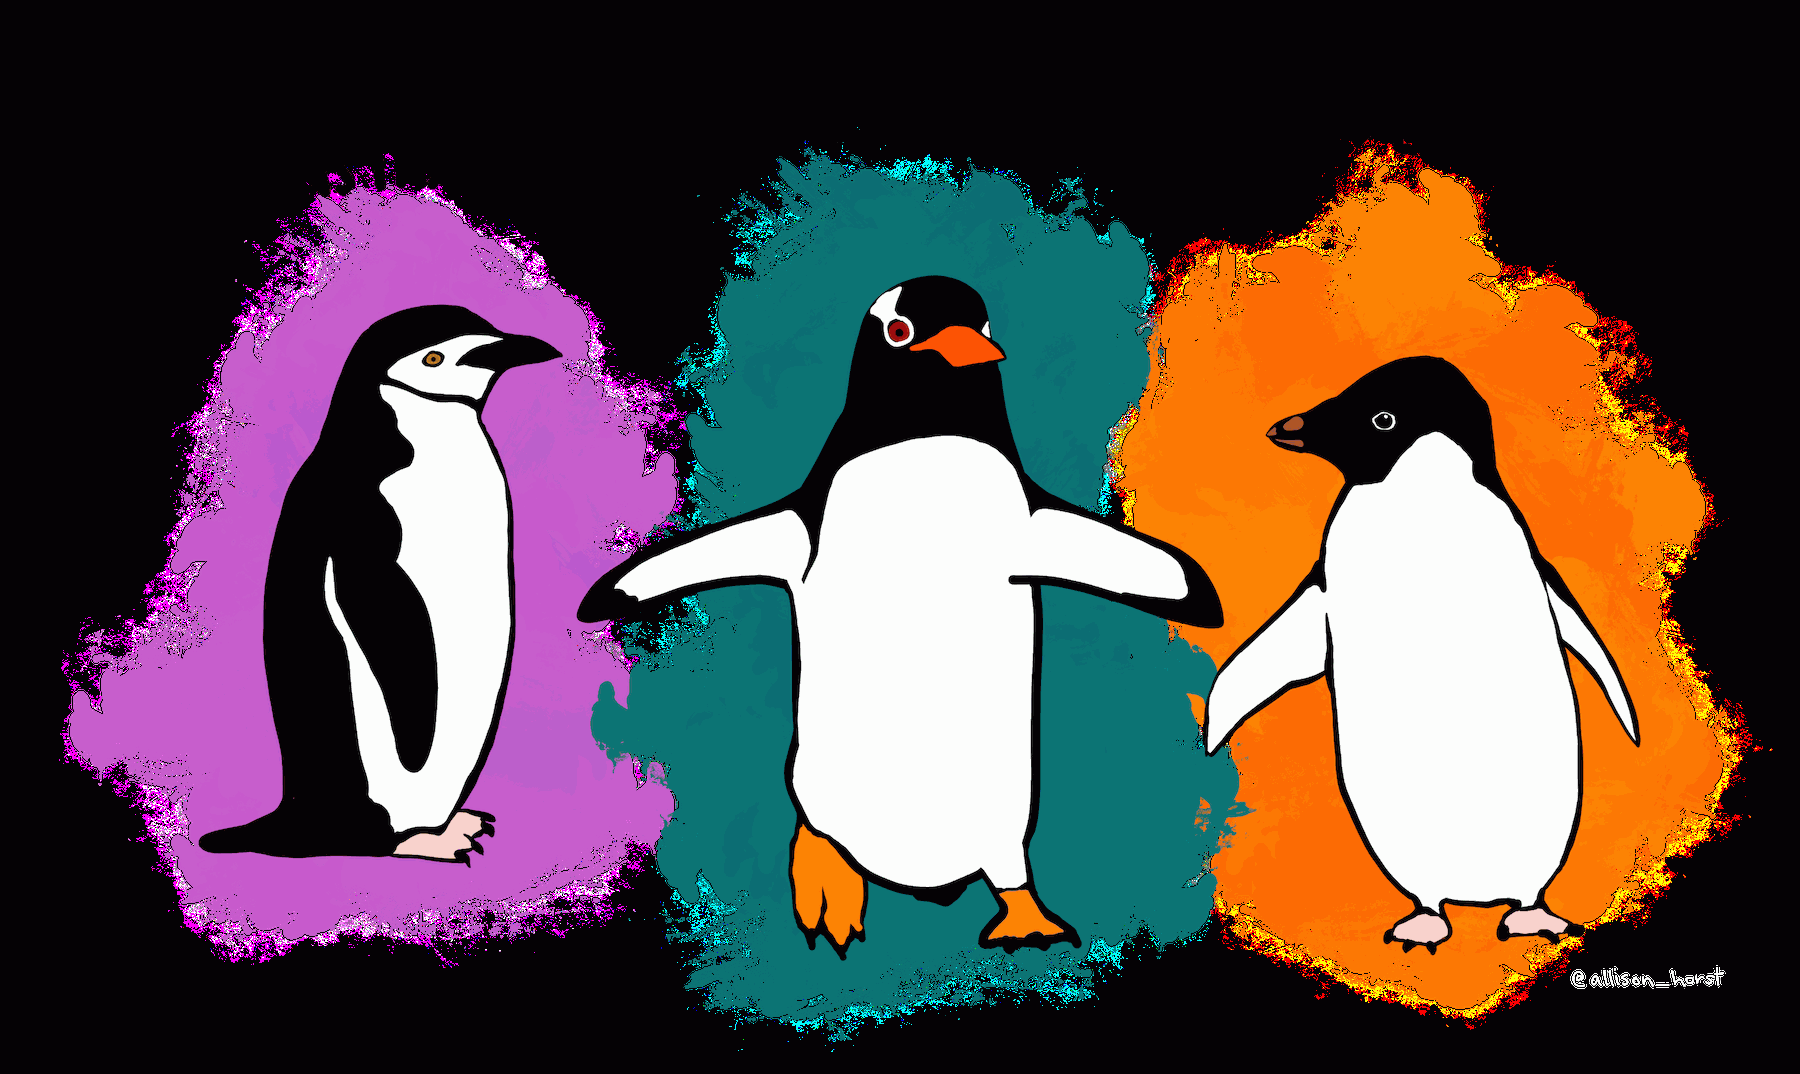
source: @allison_horst https://github.com/allisonhorst/penguins

# Big Picture

In this kernel, I will use a "[Palmer Archipelago (Antarctica) Penguin](https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data)" dataset posted on Kaggle by [Parul Pandey](https://www.kaggle.com/parulpandey) to build a model to classify 3 different species of penguins. I am going to use a __K-Nearest Neighbors__ model in this kernel.

This dataset was originally created by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network to provide a great dataset for data exploration & visualization, as an alternative to popular and classic dataset, iris. Please visit the official [GitHub](https://github.com/allisonhorst/palmerpenguins/blob/main/README.md) page for more details.

This dataset is particularly popular among the R community, but I will be using Python in this kernel.

For classification project, it is common to try multiple classification algorithms and choose the best one or combine them (ensemble), but in this kernel, we will only use K-Nearest Neighbors __as it returned a perfect score__. In the real world, achieving a perfect score is very rare, but I hope this kernel will be somewhat helpful for those who are just getting into data science as an example of data science projects.

# Table of Contents <a id = '0'></a>

1. [Select a Performance Measure](#1)
2. [Import Modules & Read the Dataset](#2)
3. [Columns and Data Type](#3) <br>
   3.1. [High-Level Overview](#3.1)<br>
   3.2. [Penguin Body Parts](#3.2)<br>
4. [Create a Training Set and Test Set](#4)<br>
5. [EDA](#5)<br>
   5.1. [Target Variable](#5.1)<br>
   5.2. [Missing Values](#5.2)<br>
6. [Build a Pipeline](#6)<br>
7. [Train, Compare, and Select a Model](#7)<br>
   7.1. [K-Nearest Neighbors](#7.1)<br>
8. [Evaluate a Model with Test Set](#8)<br>
9. [Conclusion](#9)<br>

# 1. Select a Performance Measure <a id = 1></a>
[Return to Table of Contents](#0)

In this kernel, we will utilize accuracy, precision, recall, and f1 scores to evaluate a model.

# 2. Import Modules & Read the Dataset <a id = 2></a>
[Return to Table of Contents](#0)

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
import warnings
import plotly.graph_objects as go
from itertools import combinations
from sklearn.neighbors import KNeighborsClassifier

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/palmer-archipelago-antarctica-penguin-data/penguins_size.csv
/kaggle/input/palmer-archipelago-antarctica-penguin-data/penguins_lter.csv


In [2]:
df = pd.read_csv('/kaggle/input/palmer-archipelago-antarctica-penguin-data/penguins_size.csv')

# 3. Columns and Data Type <a id = 3></a>
[Return to Table of Contents](#0)

## 3.1 High-Level Overview <a id = 3.1></a>
[Return to Table of Contents](#0)

In [3]:
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


Notes from the information above:
- The "__species__" column is our target variable where we are trying to classify.
- The "__culmen_length_mm__", "__culmen_depth_mm__", "__flipper_length_mm__", "__body_mass_g__" columns have __2__ missing values.
- The "__sex__" column has __10__ missing values.

We will handle these missing values shortly.

In [5]:
df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


Notes from the table above:
- The "body_mass_g" column is ranging between 2700g - 6300g. My quick research shows that the average weight of an adult Adélie penguin can vary, but generally, they weigh between 3 to 6 kilograms (6.6 to 13.2 pounds), which supports the weight range in this dataset. 
- The "__body_mass_g__" column has a __very different scale__ than other features. If we want to use distance-based models, like KNN, we should standardize the features before fitting the model.


We have 3 categorical features including the target variable. Let's use value_counts() and see if there are any unusual data.

In [6]:
for col in df.select_dtypes(include= 'object').columns:
    print(df[col].value_counts().sort_values(ascending = False))
    print()

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

island
Biscoe       168
Dream        124
Torgersen     52
Name: count, dtype: int64

sex
MALE      168
FEMALE    165
.           1
Name: count, dtype: int64



The "sex" column contains ".", which is most likely a wrong data entry. Let's take a closer look at it.

In [7]:
df.loc[df['sex'] == '.']

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,.


I will replace "." with a _null_ value for now. We will address missing (null) values shortly.

In [8]:
df.replace(".", np.NaN, inplace = True)
df['sex'].value_counts().sort_values(ascending = False)

sex
MALE      168
FEMALE    165
Name: count, dtype: int64

### 3.2. Penguin Body Parts <a id = 3.2></a>
[Return to Table of Contents](#0)

"culmen" is the dorsal ridge atop the bill. A penguin's flippers are located on the sides of its body, corresponding to where arms would be on other animals.


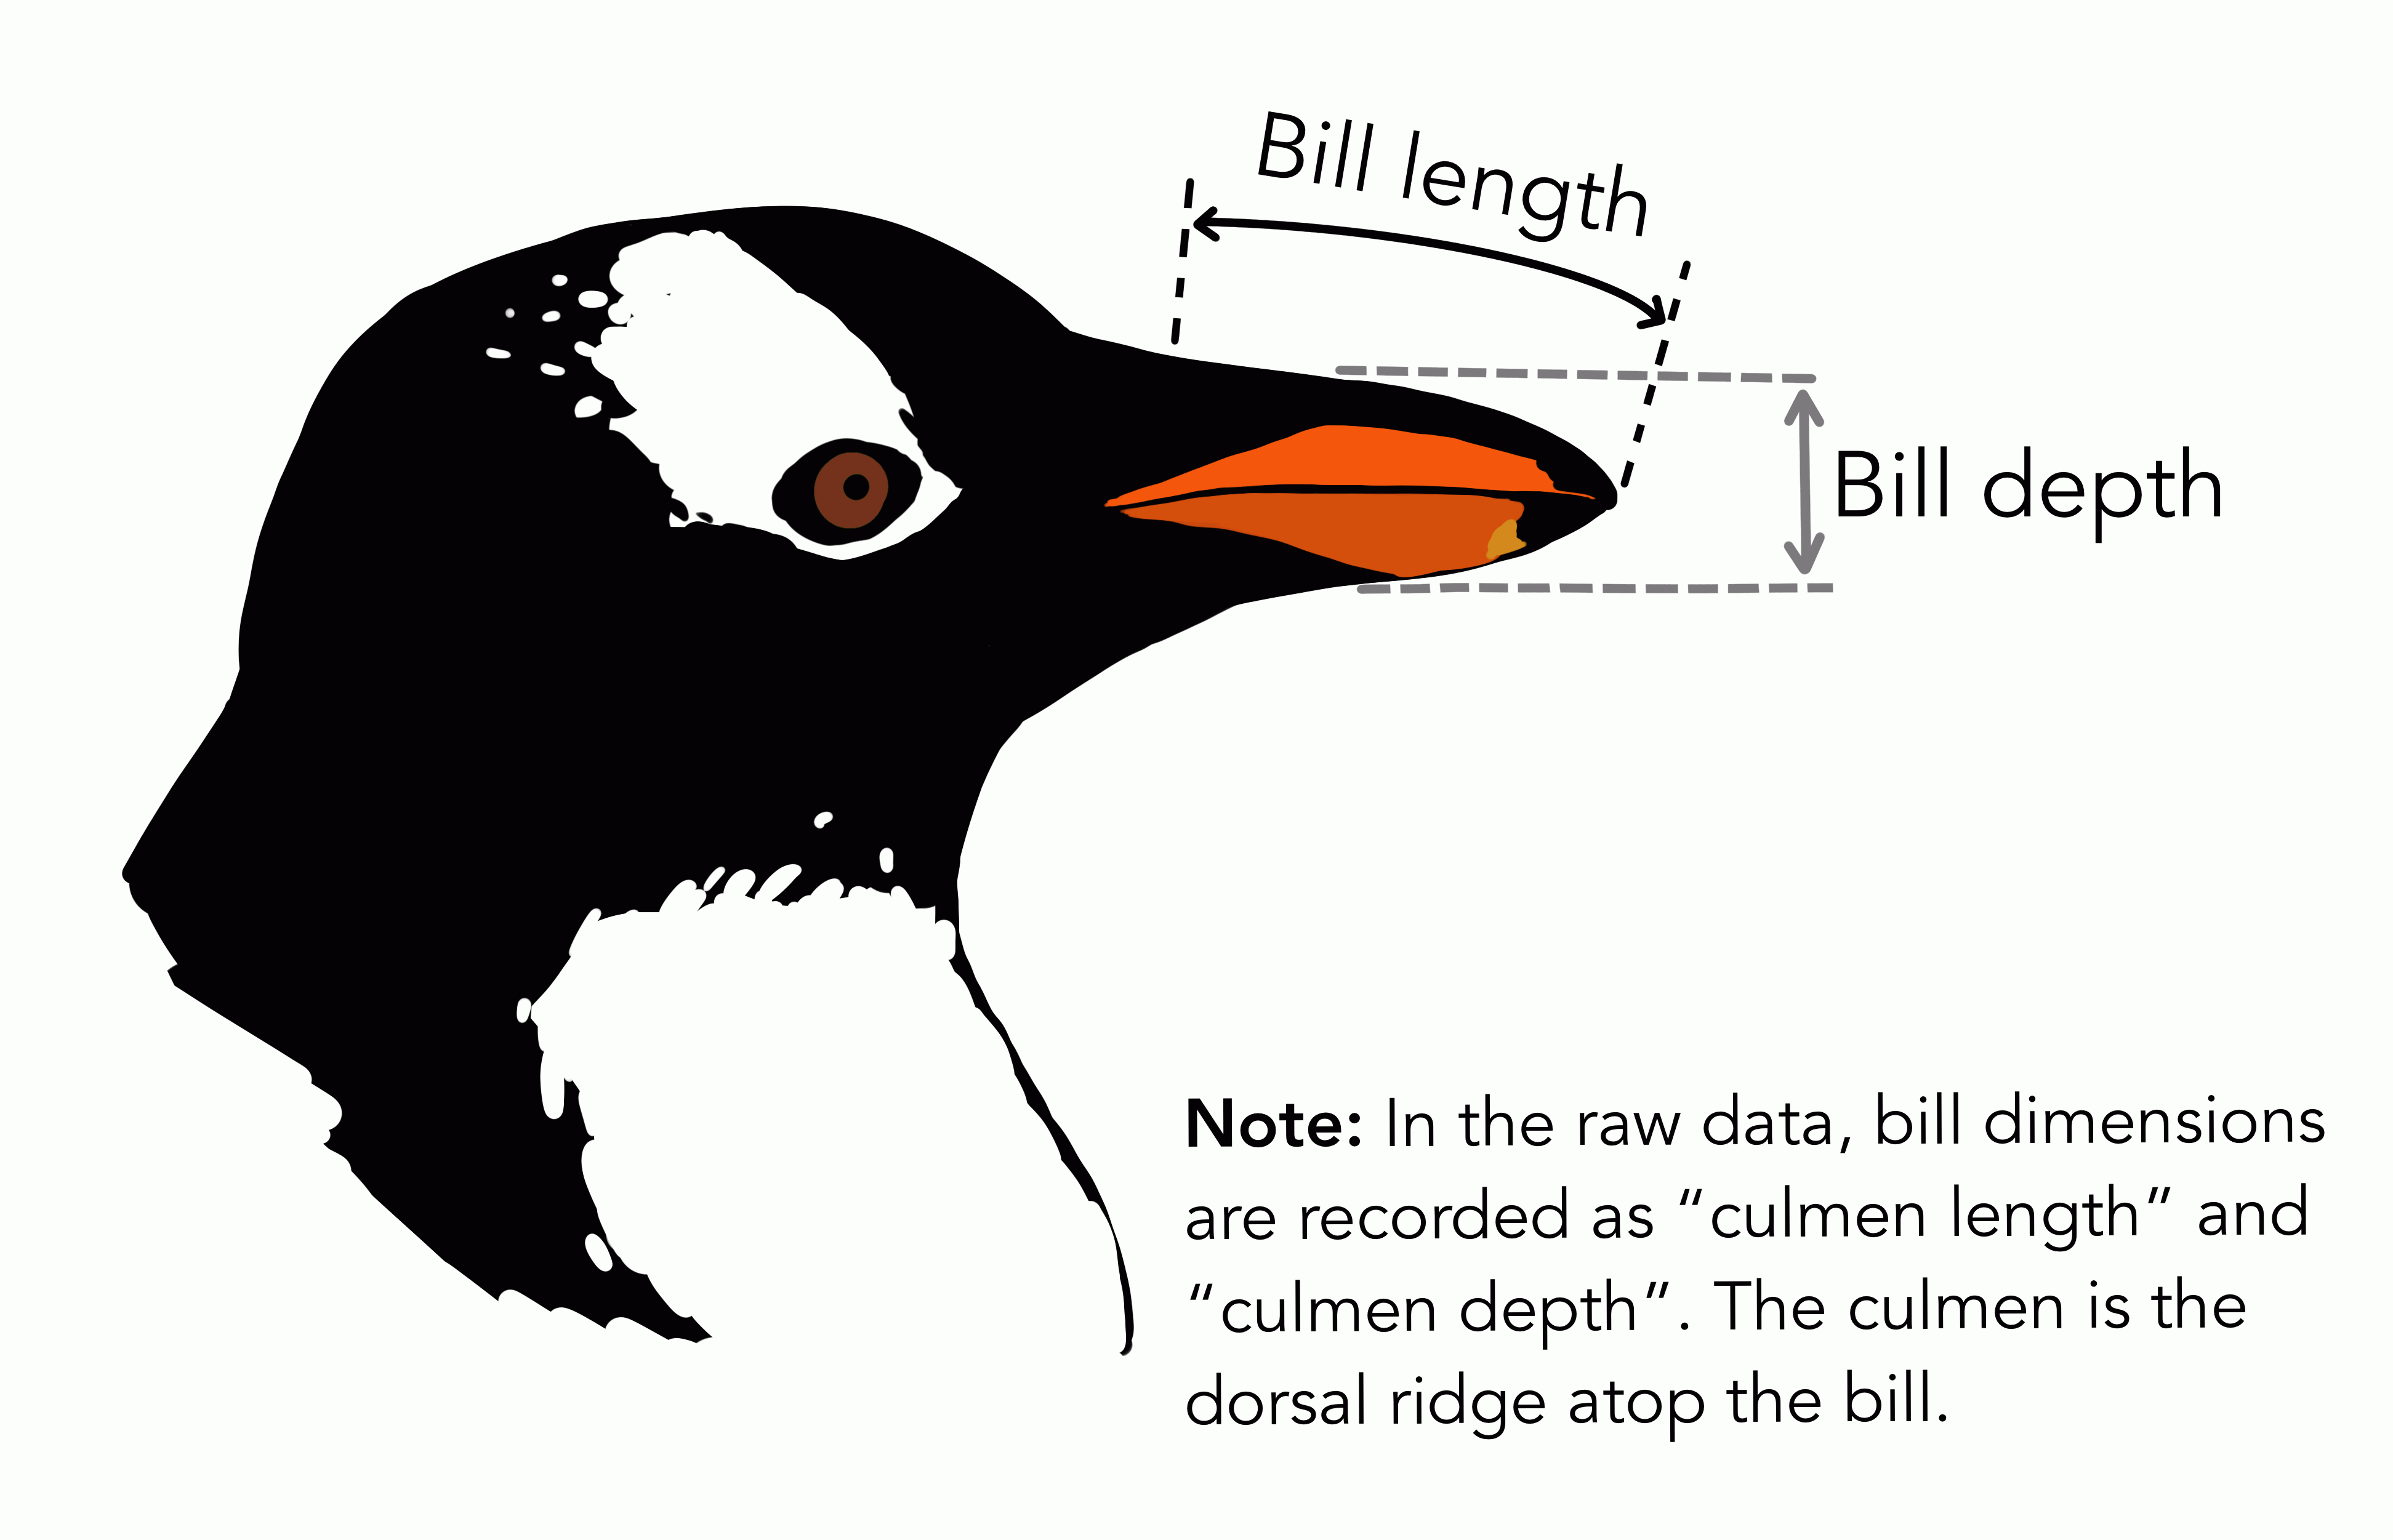

source: @allison_horst https://github.com/allisonhorst/penguins

# 4. Create a Training Set and Test Set<a id = 4></a>
[Return to Table of Contents](#0)

Before exploring the data, let's split the data into a training and test set to prevent our model from becoming too optimistic.
I usually prefer to split data into a train, cross-validation, and test set, but as this dataset is not learge, I will only create a training and test set. Moving forward, I will use the training set to explore the data.

In [9]:
train, test =  train_test_split(df, test_size = 0.2, random_state = 42)

# 5. EDA <a id = 5></a>
[Return to Table of Contents](#0)

Let's explore the data. I will make a copy of the training set so that I can revert to it later. 

In [10]:
train_eda = train.copy()

## 5.1. Target Variable <a id = 5.1></a>

Let's look at the target variable.

species
Adelie       0.436364
Gentoo       0.374545
Chinstrap    0.189091
Name: proportion, dtype: float64


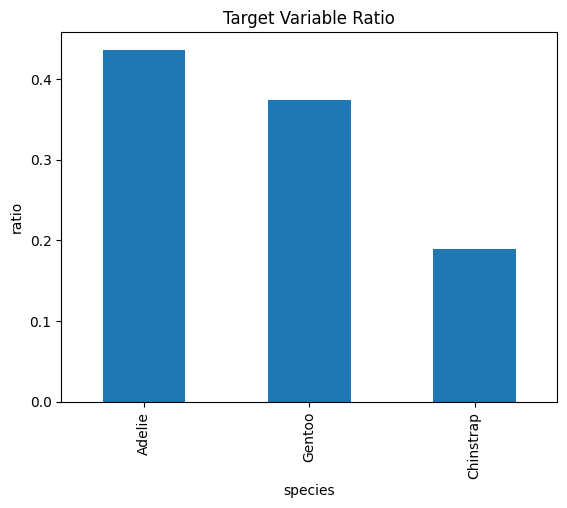

In [11]:
print(train_eda['species'].value_counts(normalize = True).sort_values(ascending = False))
train_eda['species'].value_counts(normalize = True).sort_values(ascending = False).plot.bar()
plt.title("Target Variable Ratio")
plt.ylabel("ratio");

Notes from the bar chart above:
- __Adelie__ is the most common in the dataset with __44%__ followed by __Gentoo__ with __37%__ and __Chinstrap__ with __19%__. 
- It is true that the ratio is not equal, but I believe that this dataset does not require any extra steps to manage imbalanced data.

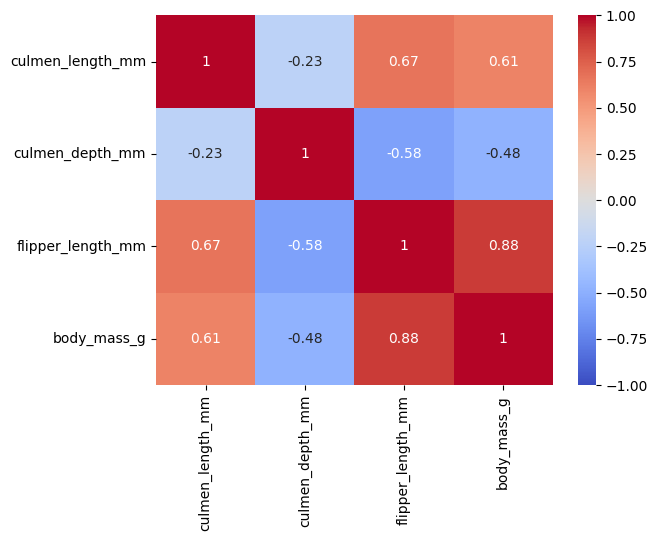

In [12]:
sns.heatmap(train_eda.corr(numeric_only = True), vmin = -1, vmax = 1, cmap = 'coolwarm', annot = True);

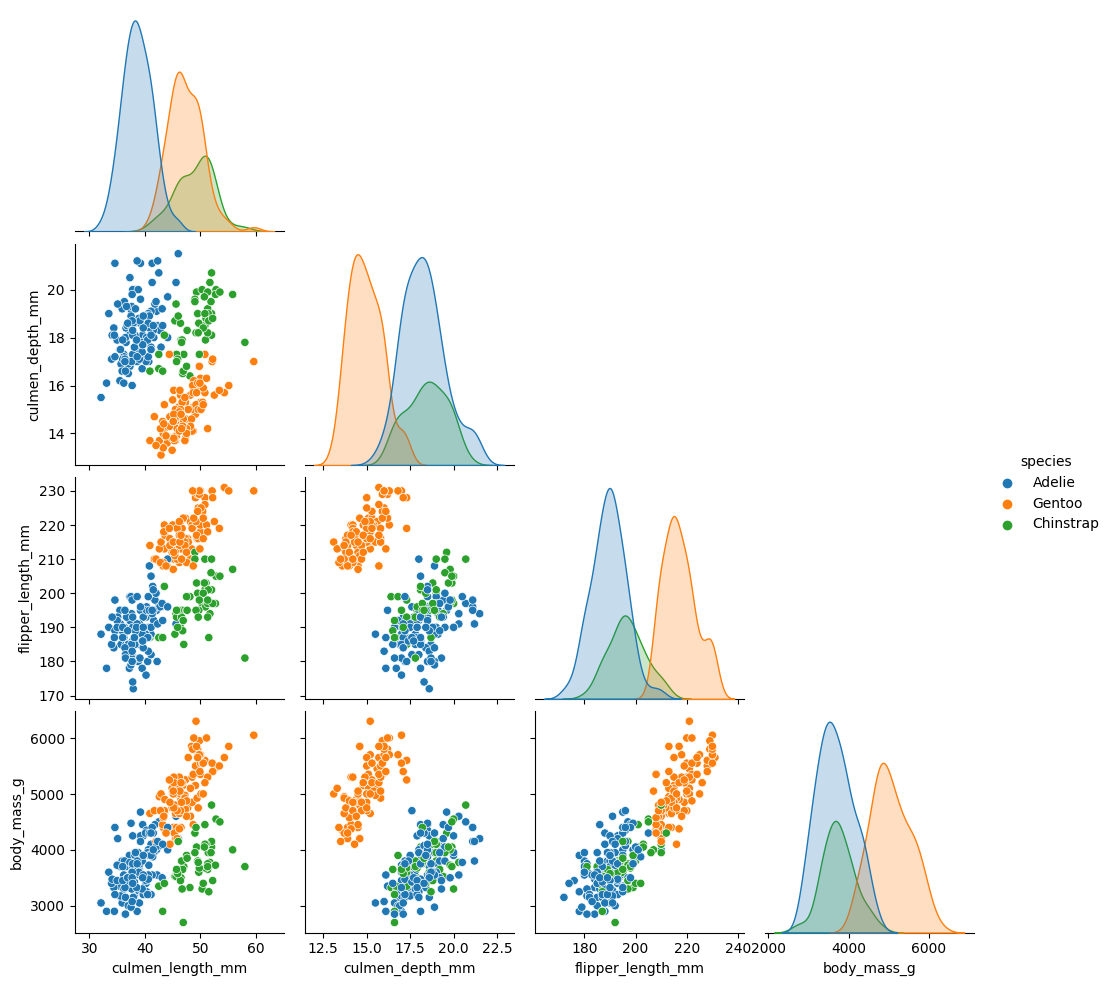

In [13]:
warnings.filterwarnings("ignore")

sns.pairplot(train_eda, hue = 'species', corner = True);

Notes from the chart above:
- The relationship between "culmen_length_mm" and other features (first column on the left) clearly shows patterns for each species.
- For other relationships, it appears that Adelie and Chinstrap share similar traits.

We can also utilize a 3D plot to see relationships among 3 features. With 4 numerical features available, there are 4 combinations of 3 features. Let's plot each combination! I will also standardize the features as the original scale of each feature varies, making the 3D chart challenging to interpret. After plotting the 3D charts, I will revert them to their original scales.

In [14]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(train_eda[['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']])
train_eda[['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']] = scaled_features

# Create an interactive 3D plot for each combination of 3 features
features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']

for combo in combinations(features, 3):
    # Create a 3D scatter plot
    fig = go.Figure(data=[go.Scatter3d(
        x=train_eda[combo[0]],
        y=train_eda[combo[1]],
        z=train_eda[combo[2]],
        mode='markers',
        marker=dict(
            size=8,
            color=pd.factorize(train_eda['species'])[0],
            colorscale='Viridis',
            opacity=0.8,
        ),
        text=train_eda['species'],
    )])

    fig.update_layout(scene=dict(
                        xaxis=dict(title=combo[0]),
                        yaxis=dict(title=combo[1]),
                        zaxis=dict(title=combo[2])),
                        scene_camera=dict(eye=dict(x=1.87, y=0.88, z=-0.64)))

    fig.update_layout(scene_dragmode='orbit', scene_aspectmode='data')

    fig.update_layout(title=f'{combo[0]} vs {combo[1]} vs {combo[2]} (Colored by species)', title_x = 0.5)

    fig.show()
    
original_scale = scaler.inverse_transform(train_eda[['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']])
train_eda[['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']] = original_scale


Now, let's examine the categorical features. I will omit the "sex" feature, as I don't believe the classification of species requires consideration of both male and female, and this feature is unlikely to contribute significantly to the classification.

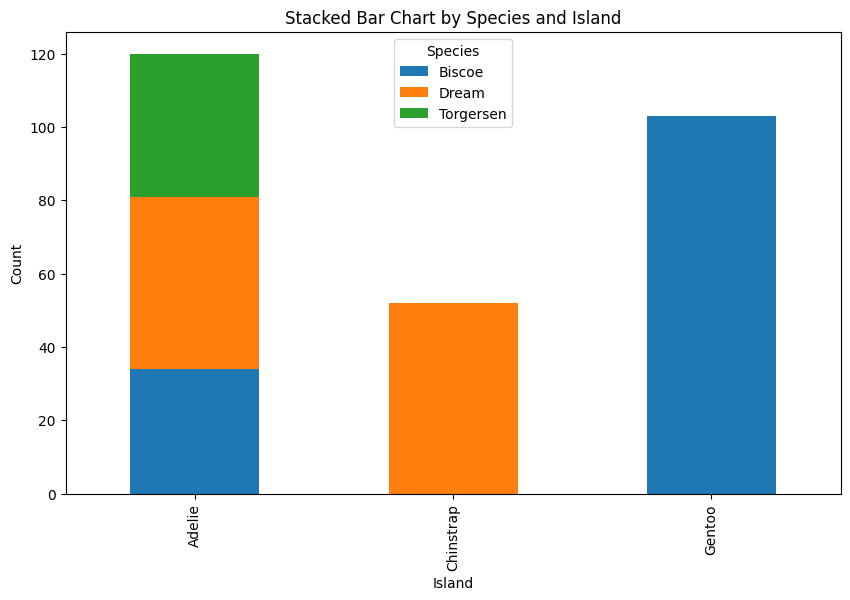

In [15]:
grouped_data = train_eda.groupby(['species', 'island']).size().unstack()

grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('Island')
plt.ylabel('Count')
plt.title('Stacked Bar Chart by Species and Island')

plt.legend(title='Species')

plt.show()

Notes from the chart above:
- It appears that Chinstrap and Gentoo only come from one island: Chinstrap from Dream, and Gentoo from Biscoe.
- In contrast to the other two, Adelie comes from multiple islands: Biscoe, Dream, and Torgersen.
- After reviewing this chart, one might be tempted to conclude, "okay then, a species is Chinstrap if it comes from the corresponding island Dream, and Gentoo if it comes from Biscoe." However, after my quick research, it seems that these species are not limited to these islands and are spread to other areas as well.

## 5.2. Missing Values <a id = 5.2></a>

It seems that there are some missing values in the dataset. Let's take a closer look at them and decide how to handle them (impute? remove?)

In [16]:
X = train_eda.drop('species', axis = 1)
y = train_eda['species']

In [17]:
X[X.isna().any(axis = 1)].sort_index()

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
8,Torgersen,34.1,18.1,193.0,3475.0,NaN
10,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Dream,37.5,18.9,179.0,2975.0,NaN
246,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Biscoe,47.3,13.8,216.0,4725.0,NaN
339,Biscoe,NaN,NaN,NaN,NaN,NaN


I usually prefer to impute missing values rather than remove them. There are multiple ways of imputations, but for this dataset, I will use scikit-learn's "__KNNImputer__" to fill in null values in the numerical columns. "KNNImputer" replaces each missing value with the mean of the _k_-nearest neighbors's values for that feature. __The distance is based on all the available features__. Since I do not want KNNImputer to use the "species" target variable in its calculation, I created a variable X for independent features and y for the target feature. For categorical features ("island" and "sex"), I will simply replace missing values with the most frequent values.

In [18]:
num_cols = X.select_dtypes(include= np.number).columns
cat_cols = X.select_dtypes(include= 'object').columns

knn_imputer = KNNImputer(n_neighbors=10) 
X[num_cols] = knn_imputer.fit_transform(X[num_cols]).round(1)

spl_imputer = SimpleImputer(strategy='most_frequent')
X[cat_cols] = spl_imputer.fit_transform(X[cat_cols])

In [19]:
X.loc[[8, 10, 11, 47, 246, 286, 324, 339], :]

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
8,Torgersen,34.1,18.1,193.0,3475.0,FEMALE
10,Torgersen,37.8,17.1,186.0,3300.0,FEMALE
11,Torgersen,37.8,17.3,180.0,3700.0,FEMALE
47,Dream,37.5,18.9,179.0,2975.0,FEMALE
246,Biscoe,44.5,14.3,216.0,4100.0,FEMALE
286,Biscoe,46.2,14.4,214.0,4650.0,FEMALE
324,Biscoe,47.3,13.8,216.0,4725.0,FEMALE
339,Biscoe,43.8,17.1,201.2,4202.9,FEMALE


# 6. Build a Pipeline <a id = 6></a>
[Return to Table of Contents](#0)

Now, the data is ready, but before fitting the data, let's create a pipeline for the preprocessing steps.

In [20]:
num_pipeline = Pipeline([
    ('knnimputer', KNNImputer(n_neighbors = 10)),
    ('standardize', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehotencoder', OneHotEncoder(drop = 'first', handle_unknown = 'ignore'))
])

preprocessing = ColumnTransformer([
    ('num_features', num_pipeline, num_cols),
    ('cat_features', cat_pipeline, cat_cols)
])

In [21]:
X_train = train.drop('species', axis = 1)
y_train = train['species']
X_test = test.drop('species', axis = 1)
y_test = test['species']

X_train = preprocessing.fit_transform(X_train)
X_test = preprocessing.transform(X_test)

# 7. Train, Compare, and Select a Model <a id = 7></a>
[Return to Table of Contents](#0)

Let's start with KNN.

## 7.1. K-Nearest Neighbors <a id = 7.1></a>

In [22]:
k = 10
knn = KNeighborsClassifier(n_neighbors = k)

knn.fit(X_train, y_train)

print(f'Train Accuracy: {knn.score(X_train, y_train).round(2)}')
print(f'Train Precision: {precision_score(y_train, knn.predict(X_train), average = None).round(2)}')
print(f'Train Recall: {recall_score(y_train, knn.predict(X_train), average = None).round(2)}')
print(f'Train F1: {f1_score(y_train, knn.predict(X_train), average = None).round(2)}')
print('Confusion Matrix:')
print(confusion_matrix(y_train, knn.predict(X_train)))

Train Accuracy: 0.99
Train Precision: [0.99 0.98 1.  ]
Train Recall: [1.   0.98 0.99]
Train F1: [1.   0.98 1.  ]
Confusion Matrix:
[[120   0   0]
 [  1  51   0]
 [  0   1 102]]


The KNeighborsClassifier does a really good job and has only 2 misclassifications. It is rare to achieve such a high score without tuning any parameters. It is possible that the model is overfitting the training data. Let's use GridSearchCV to tune hyperparameters and also evaluate its performance with the test set.

In [23]:
params = {
    'n_neighbors': range(1, 50),
    'metric': ['minkowski', 'manhattan'],
    'weights': ['uniform', 'distance']
}

gridsearch = GridSearchCV(KNeighborsClassifier(), params)

gridsearch.fit(X_train, y_train)

gridsearch.best_params_

{'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'uniform'}

In [24]:
knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', weights = 'uniform')

knn.fit(X_train, y_train)

print(f'Train Accuracy: {knn.score(X_train, y_train).round(2)}')
print(f'Train Precision: {precision_score(y_train, knn.predict(X_train), average = None).round(2)}')
print(f'Train Recall: {recall_score(y_train, knn.predict(X_train), average = None).round(2)}')
print(f'Train F1: {f1_score(y_train, knn.predict(X_train), average = None).round(2)}')
print('Confusion Matrix:')
print(confusion_matrix(y_train, knn.predict(X_train)))

Train Accuracy: 1.0
Train Precision: [0.99 1.   1.  ]
Train Recall: [1.   1.   0.99]
Train F1: [1. 1. 1.]
Confusion Matrix:
[[120   0   0]
 [  0  52   0]
 [  1   0 102]]


We achieved a slightly better result by tuning some hyperparameters. Now, let's evaluate the model with the test data.

# 8. Evaluate a Model with Test Set <a id = 8></a>
[Return to Table of Contents](#0)

In [25]:
print(f'TestAccuracy: {knn.score(X_test, y_test).round(2)}')
print(f'Test Precision: {precision_score(y_test, knn.predict(X_test), average = None).round(2)}')
print(f'Test Recall: {recall_score(y_test, knn.predict(X_test), average = None).round(2)}')
print(f'Test F1: {f1_score(y_test, knn.predict(X_test), average = None).round(2)}')
print('Confusion Matrix:')
print(confusion_matrix(y_test, knn.predict(X_test)))

TestAccuracy: 1.0
Test Precision: [1. 1. 1.]
Test Recall: [1. 1. 1.]
Test F1: [1. 1. 1.]
Confusion Matrix:
[[32  0  0]
 [ 0 16  0]
 [ 0  0 21]]



We achieved a perfect score! This means that the model classified the three different species with 100% accuracy for the unseen data. However, it is very rare to see this level of accuracy for all measures (accuracy, precision, recall, f1) in the real world. In fact, this dataset only has 344 observations. As we acquire more observations, there will be a greater variety of data, and the model will have more opportunities to misclassify, resulting in lower predictive accuracy.

Nevertheless, it is evident that the KNN algorithm performs exceptionally well with this dataset.

Several reasons explain why KNN worked effectively for this dataset:
1. Very small dataset: 
    - KNN usually works well with small-to-mid-sized datasets.
2. Very few features: 
    - KNN performance can degrade in high-dimensional spaces due to the curse of dimensionality, where the concept of distance becomes less meaningful as the number of dimensions increases. This dataset only has 7 features (after OneHotEncoding).
3. No outliers: 
    - KNN is distance-based and sensitive to outliers, but this dataset did not contain any influential outliers.
4. Balanced (enough) data: 
    - KNN may not perform well on imbalanced datasets, where one class significantly outnumbers the others. This dataset was fairly balanced.

# 9. Conclusion <a id = 9></a>
[Return to Table of Contents](#0)

Thank you very much for reading my kernel. Please note that while I only used the KNN model in this kernel, there are many other options that can handle multi-class classification, such as Logistic Regression, Decision Tree, etc. As mentioned earlier, it is more common to try multiple classification models and pick the best model or combined them to bring your model to the next level. If you liked this kernel, __please upvote__, and any __feedback/comment__ is much appreciated!

Best,                  
Seiji